In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Packages 
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib
import missingno as mo
import statistics
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)


## model package 
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

In [10]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
#target= train_data['saleprice']
# -------------------------------------# 
# train_data.head()
# test_data.head()
# train_data.info()
#test_data.sample()
# train_data.dtypes
print("Train:" + str(train_data.shape))
print("Test:" + str(test_data.shape))

Train:(1460, 81)
Test:(1459, 80)


In [11]:
## lowercase
train_data.columns = map(str.lower, train_data.columns)
test_data.columns = map(str.lower, test_data.columns)
#train_data.columns
#test_data.columns

In [12]:
train_data.drop('id',axis = 1, inplace = True)
test_data.drop('id',axis = 1, inplace = True)

In [13]:
y = train_data.saleprice

In [14]:
# Skewness, Kurtosis before log transformation
print("Skewness: %f" % y.skew())
print("Kurtosis: %f" % y.kurt())

Skewness: 1.882876
Kurtosis: 6.536282


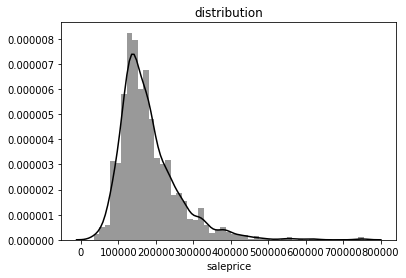

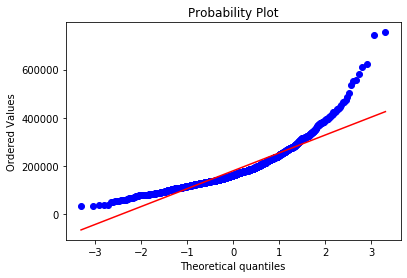

In [16]:
## Showing skewness
## right-skewed , forming Normality
sns.distplot(y, color = 'black')
plt.title('distribution')
plt.show()
stats.probplot(y, plot=plt) ## plottting
plt.show()

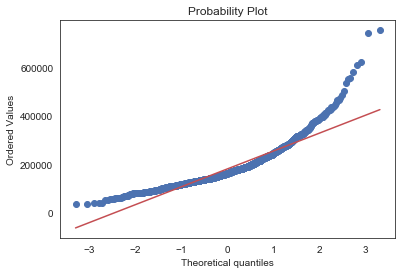

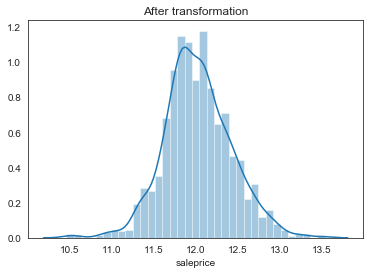

In [38]:
## log transformation
## Normal distributed 
y = np.log1p(y)
sns.distplot(y);
plt.title('After transformation')
plt.show()

In [39]:
## after transformation Skewness, Kurtosis
print("Skewness: %f" % y.skew())
print("Kurtosis: %f" % y.kurt())

Skewness: 0.121347
Kurtosis: 0.809519


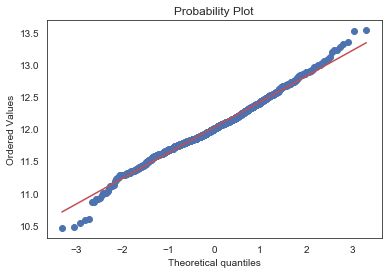

In [40]:
stats.probplot(y, plot=plt) ## plotting 
plt.show()

In [41]:
## storing all features
features_all = pd.concat([train_data,test_data]).reset_index(drop=True)
features_all = features_all.drop(['saleprice'], axis = 1)
features_all.dtypes

1stflrsf         int64
2ndflrsf         int64
3ssnporch        int64
alley           object
bedroomabvgr     int64
                 ...  
utilities       object
wooddecksf       int64
yearbuilt        int64
yearremodadd     int64
yrsold           int64
Length: 79, dtype: object

In [42]:
missing = features_all.isnull().sum()
count =  features_all.isnull().count()
percent = (missing / count) * 100 
percent = percent[percent > 0].sort_values(ascending=False)

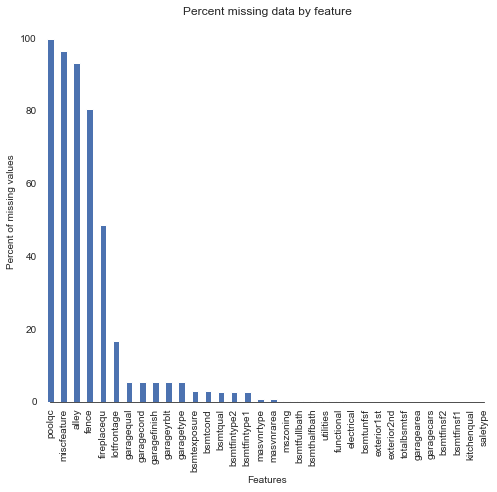

In [43]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')
percent.plot.bar(color="b")
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

In [44]:
def fillin_missing(features):
    # the data description states that NA refers to typical ('Typ') values
    features['functional'] = features['functional'].fillna('Typ')
    # Replace the missing values in each of the columns below with their mode
    features['electrical'] = features['electrical'].fillna("SBrkr")
    features['kitchenqual'] = features['kitchenqual'].fillna("TA")
    features['exterior1st'] = features['exterior1st'].fillna(features['exterior1st'].mode()[0])
    features['exterior2nd'] = features['exterior2nd'].fillna(features['exterior2nd'].mode()[0])
    features['saletype'] = features['saletype'].fillna(features['saletype'].mode()[0])
    #features['mszoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # the data description stats that NA refers to "No Pool"
    features["poolqc"] = features["poolqc"].fillna("None")
    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('garageyrblt', 'garagearea', 'garagecars'):
        features[col] = features[col].fillna(0)
    # Replacing the missing values with None
    for col in ['garagetype', 'garagefinish', 'garagequal', 'garagecond']:
        features[col] = features[col].fillna('None')
    # NaN values for these categorical basement features, means there's no basement
    for col in ('bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2'):
        features[col] = features[col].fillna('None')
        
    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    #features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    objects = []
    for i in features.columns:
        if features[i].dtype == 'object':
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # And we do the same thing for numerical features, but this time with 0s
    numeric = []
    for i in features.columns:
        if features[i].dtype != "object":
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

features_all = fillin_missing(features_all)


# missing = features_all.isnull().sum()
# count =  features_all.isnull().count()
# percent = (missing / count) * 100 
# percent = percent[percent > 0].sort_values(ascending=False)
# missing[0:10]

In [45]:
## Creating New features
features_all['total_homequal'] = features_all['overallqual'] + features_all['overallcond']
features_all['total_sf'] = features_all['totalbsmtsf'] + features_all['1stflrsf'] + features_all['2ndflrsf']
features_all['year_blt_r'] = features_all['yearbuilt'] + features_all['yearremodadd']
features_all['total_sqr'] = features_all['bsmtfinsf1'] + features_all['bsmtfinsf2'] + features_all['1stflrsf'] + features_all['2ndflrsf']

In [66]:
category_features = features_all.dtypes[features_all.dtypes == 'object']
num_features = features_all.dtypes[features_all.dtypes != 'object']

In [47]:
y.shape, features_all.shape

((1460,), (2919, 83))

In [48]:
train = features_all.iloc[:len(y), :]
test = features_all.iloc[len(y):, :]
print(train.shape, test.shape, features_all.shape)
train_data.shape,test_data.shape

(1460, 83) (1459, 83) (2919, 83)


((1460, 80), (1459, 79))

In [49]:
features_dummies = pd.get_dummies(train).iloc[:features_all.shape[0]]
features_dummies.shape

(1460, 306)

In [50]:
from sklearn.model_selection import cross_val_score
rr = Ridge(alpha=10)
rr.fit(features_dummies, y)
np.sqrt(-cross_val_score(rr, features_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.13890800453983362

In [51]:
y_pred = rr.predict(features_dummies)
resid = y - y_pred
mean_resid = resid.mean()
std_resid = resid.std()
z = (resid - mean_resid) / std_resid
z = np.array(z)
outliers1 = np.where(abs(z) > abs(z).std() * 3)[0]
outliers1

array([  30,   88,  142,  277,  308,  328,  365,  410,  438,  462,  495,
        523,  533,  581,  588,  628,  632,  681,  688,  710,  714,  728,
        774,  812,  874,  898,  916,  935,  968,  970, 1062, 1168, 1181,
       1182, 1298, 1324, 1383, 1423, 1432, 1453], dtype=int64)

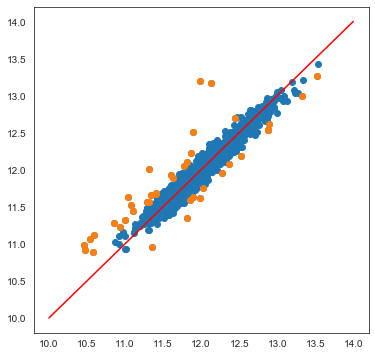

In [52]:
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred)
plt.scatter(y.iloc[outliers1], y_pred[outliers1])
plt.plot(range(10, 15), range(10, 15), color="red")

In [53]:
er = ElasticNet(alpha=0.001, l1_ratio=0.58)
er.fit(features_dummies, y)
np.sqrt(-cross_val_score(rr, features_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean()

C:\Users\Evinl\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.994657853414022, tolerance: 0.02327976343365451
  positive)


0.13890800453983362

In [54]:
y_pred = er.predict(features_dummies)
resid = y - y_pred
mean_resid = resid.mean()
std_resid = resid.std()
z = (resid - mean_resid) / std_resid
z = np.array(z)
outliers2 = np.where(abs(z) > abs(z).std() * 3)[0]
outliers2

array([  30,   88,  142,  277,  328,  410,  457,  462,  495,  523,  533,
        581,  588,  628,  632,  666,  681,  688,  710,  714,  728,  738,
        774,  812,  874,  898,  916,  968,  970, 1181, 1182, 1298, 1324,
       1383, 1423, 1432, 1453], dtype=int64)

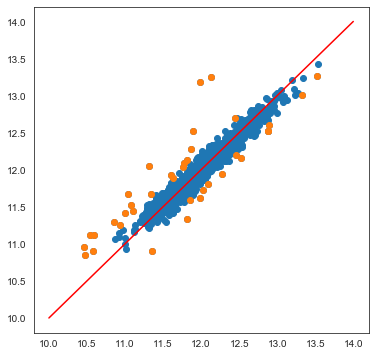

In [55]:
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred)
plt.scatter(y.iloc[outliers2], y_pred[outliers2])
plt.plot(range(10, 15), range(10, 15), color="red")

In [65]:
outliers = []
for i in outliers1:
    for j in outliers2:
        if i == j:
            outliers.append(i)
    outliers
train.drop(train[train[30, 88, 142, 277, 328, 410, 462, 495, 523, 533, 581, 588, 628, 632, 681, 688, 710, 714, 728, 774, 812, 874, 898, 916, 968, 970, 1181, 1182, 1298, 1324, 1383, 1423, 1432, 1453]])
#features_all = pd.concat([train_data,test_data]).reset_index(drop=True)

KeyError: (30, 88, 142, 277, 328, 410, 462, 495, 523, 533, 581, 588, 628, 632, 681, 688, 710, 714, 728, 774, 812, 874, 898, 916, 968, 970, 1181, 1182, 1298, 1324, 1383, 1423, 1432, 1453)

((1460, 83), (1460,))

In [74]:
missing = train_data.isnull().sum()
count =  train_data.isnull().count()
percent = (missing / count) * 100 
percent[percent > 0].sort_values(ascending=False)

poolqc          99.520548
miscfeature     96.301370
alley           93.767123
fence           80.753425
fireplacequ     47.260274
lotfrontage     17.739726
garageyrblt      5.547945
garagetype       5.547945
garagefinish     5.547945
garagequal       5.547945
garagecond       5.547945
bsmtfintype2     2.602740
bsmtexposure     2.602740
bsmtfintype1     2.534247
bsmtcond         2.534247
bsmtqual         2.534247
masvnrarea       0.547945
masvnrtype       0.547945
electrical       0.068493
dtype: float64

dtype('int64')

In [126]:
missing = train_data.isnull().sum()
count =  train_data.isnull().count()
percent = (missing / count) * 100 
percent[percent > 0].sort_values(ascending=False)

poolqc          99.520548
miscfeature     96.301370
alley           93.767123
fence           80.753425
fireplacequ     47.260274
lotfrontage     17.739726
garageyrblt      5.547945
garagetype       5.547945
garagefinish     5.547945
garagequal       5.547945
garagecond       5.547945
bsmtfintype2     2.602740
bsmtexposure     2.602740
bsmtfintype1     2.534247
bsmtcond         2.534247
bsmtqual         2.534247
masvnrarea       0.547945
masvnrtype       0.547945
electrical       0.068493
dtype: float64

In [315]:
## Once done with elasticNet, feature selection

In [ ]:
## Correlation heatmap
# num_corr = num_f.corr()
# f, ax = plt.subplots(figsize=(20, 9))
# sns.heatmap(num_corr, vmax=.8,annot_kws={'size': 10}, annot=True); 
# plt.show()

In [ ]:
# ## Train : breaking down numeric and categorical
# ntype = train_data.dtypes[train_data.dtypes != 'object']
# ctype = train_data.dtypes[train_data.dtypes == 'object']
# print("Train: ")
# print ("total # of numeric :" + str(len(ntype)))
# print ("total # of categoerical :" + str(len(ctype)))
# print(" ---------------------------------- ")
# print("Test: ")
# ## Test : breaking down numeric and categorical
# ntype1 = test_data.dtypes[test_data.dtypes != 'object']
# ctype1 = test_data.dtypes[test_data.dtypes == 'object']
# print ("total # of numeric :" + str(len(ntype1)))
# print ("total # of categoerical :" + str(len(ctype1)))